# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Reading the data

In [12]:
data = pd.read_csv("E:/malay/Downloads/archive (2)/tested.csv")
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,0,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,1,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,0,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,0,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,1,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [4]:
data.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

### Checking missing values

In [64]:
data.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

### Dropping Duplicates

In [65]:
data.drop_duplicates(inplace= True)

### Filling Age Column

In [66]:
mean_age_miss = data[data["Name"].str.contains('Miss.', na=False)]['Age'].mean().round()
mean_age_mrs = data[data["Name"].str.contains('Mrs.', na=False)]['Age'].mean().round()
mean_age_mr = data[data["Name"].str.contains('Mr.', na=False)]['Age'].mean().round()
mean_age_master = data[data["Name"].str.contains('Master.', na=False)]['Age'].mean().round()

print("The mean age of Miss title: ",mean_age_miss)
print("The mean age of Mrs title: ",mean_age_mrs)
print("The mean age of Mr title: ",mean_age_mr)
print("The mean age of Master: ",mean_age_master)

def filling_age(name_age): 
    name = name_age[0]
    age = name_age[1]
    if pd.isnull(age):
        if 'Mr.' in name:
            return mean_age_mr
        if 'Mrs.' in name:
            return mean_age_mrs
        if 'Miss.' in name:
            return mean_age_miss
        if 'Master.' in name:
            return mean_age_master
        if 'Ms.' in name:
            return mean_age_miss
    else:
        return age
data['Age'] = data[['Name', 'Age']].apply(filling_age,axis=1)

The mean age of Miss title:  22.0
The mean age of Mrs title:  39.0
The mean age of Mr title:  34.0
The mean age of Master:  7.0


### Filling fare column

In [67]:
mean_c3 = data.Fare[data.Pclass == 3].mean()
data['Fare'].fillna(value=mean_c3, inplace=True)

### Dropping cabin column

In [68]:
data.drop(['Cabin'], axis=1, inplace=True)

In [69]:
# Checking missing values
data.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

### Dropping unwanted columns

In [70]:
data.drop(['PassengerId', 'Name', 'Ticket', 'SibSp', 'Parch'], axis=1, inplace=True)

# Exploratory Data Analysis

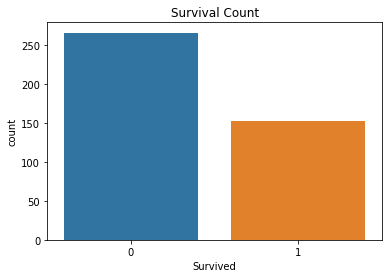

In [71]:
# Exploring the target variable
sns.countplot(x='Survived', data=data)
plt.title('Survival Count')
plt.show()

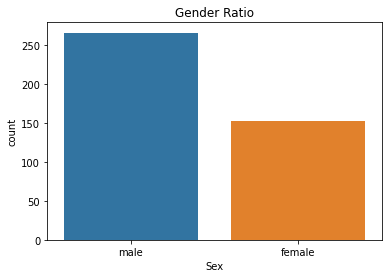

In [72]:
# Exploring categorical variables
sns.countplot(x='Sex', data=data)
plt.title('Gender Ratio')
plt.show()

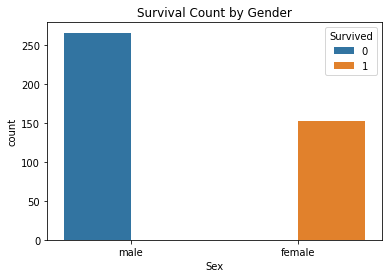

In [73]:
sns.countplot(x='Sex', hue='Survived', data=data)
plt.title('Survival Count by Gender')
plt.show()

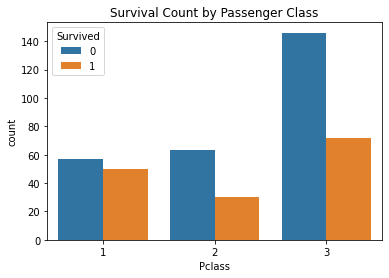

In [74]:
sns.countplot(x='Pclass', hue='Survived', data=data)
plt.title('Survival Count by Passenger Class')
plt.show()

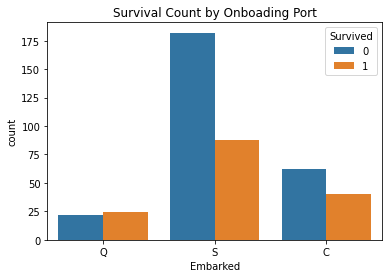

In [75]:
sns.countplot(x='Embarked', hue='Survived', data=data)
plt.title('Survival Count by Onboading Port')
plt.show()

## Encoding categoical Variables

In [76]:
categories = {"female": 1, "male": 0}
data['Sex']= data['Sex'].map(categories)

new_data = pd.concat([data, pd.get_dummies(data['Embarked'],drop_first=True)], axis=1) 

new_data.drop(['Embarked'], axis=1, inplace=True)

## Correlation plot

<AxesSubplot:>

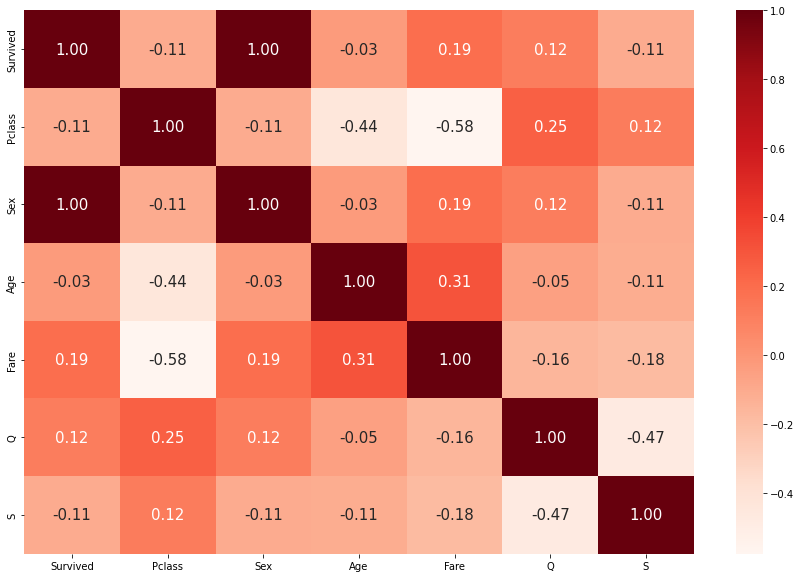

In [77]:
 corr = new_data.corr()
corr
plt.figure(figsize=(15,10))
sns.heatmap(corr, cbar=True, fmt='.2f', annot=True, annot_kws={'size':15}, cmap='Reds')

### Dropping the sex column as it may lead to overfitting

In [78]:
new_data.drop(['Sex'], axis=1, inplace=True)

### Histogram plots for the Age and  Fare columns

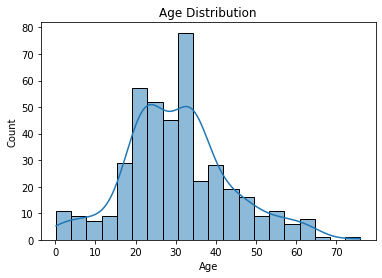

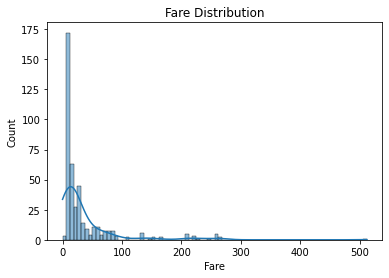

In [79]:
sns.histplot(x='Age', data=new_data, kde=True)
plt.title('Age Distribution')
plt.show()

sns.histplot(x='Fare', data=new_data, kde=True)
plt.title('Fare Distribution')
plt.show()

# Outlier Removal

In [80]:
# Calculate IQR
q1 = new_data['Fare'].quantile(0.25)
q3 = new_data['Fare'].quantile(0.75)
iqr = q3 - q1

# Define range
lower_range = q1 - 1.5 * iqr
upper_range = q3 + 1.5 * iqr

# Identify outliers
outlier_indices = new_data[(new_data['Fare'] < lower_range) | (new_data['Fare'] > upper_range)].index

# Remove outliers
cleaned_data = new_data.drop(outlier_indices)

# Data Modelling

In [81]:
## Splitting the data
X = cleaned_data.drop(['Survived'], axis=1)
y = cleaned_data['Survived']

In [82]:
## Data normalization 
mns = MinMaxScaler()
X = pd.DataFrame(mns.fit_transform(X), columns=X.columns)

In [83]:
## Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=42)

In [84]:
## Random Forest Regressor
rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=2)
rf.fit(X_train, y_train)
print('Training score: ', round(rf.score(X_train, y_train),3))
print('Testing score: ', round(rf.score(X_test, y_test),3))

Training score:  0.812
Testing score:  0.703


In [85]:
## Logistic Regression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
print('Training score: ', round(logreg.score(X_train, y_train),3))
print('Testing score: ', round(logreg.score(X_test, y_test),3))

Training score:  0.676
Testing score:  0.637


In [86]:
## Support Vector Machine
svm = SVC()
svm.fit(X_train, y_train)
print('Training score: ', round(svm.score(X_train, y_train),3))
print('Testing score: ', round(svm.score(X_test, y_test),3))

Training score:  0.676
Testing score:  0.615


In [87]:
## K-Nearest Neighbours
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
print('Training score: ', round(knn.score(X_train, y_train),3))
print('Testing score: ', round(knn.score(X_test, y_test),3))

Training score:  0.772
Testing score:  0.703
